## 參考
- [TF hub - BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=zh-tw)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# TF BERT 的相依套件

!pip install tensorflow-text

     |████████████████████████████████| 4.3 MB 8.2 MB/s 


In [3]:
# BERT的optimizer

!pip install -q tf-models-official

     |████████████████████████████████| 1.6 MB 8.3 MB/s 
     |████████████████████████████████| 99 kB 10.8 MB/s 
     |████████████████████████████████| 636 kB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.7 MB/s 
     |████████████████████████████████| 352 kB 55.1 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 679 kB 40.4 MB/s 
     |████████████████████████████████| 211 kB 74.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 


In [4]:
import os
import shutil           # 複製以及取得資料夾的套件

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization       # AdamW optimizer

import matplotlib.pyplot as plt


In [6]:
# 讀取IMDB 資料集

url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = keras.utils.get_file(
    fname='aclImdb_v1.tar.gz',
    origin=url,
    untar=True,
    cache_dir='.',
    cache_subdir=''
)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# 刪除沒用到的folders
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(path=remove_dir)      # recursive 刪除資料夾

84131840/84125825 [==============================] - 1s 0us/step


In [7]:
# 使用text_dataset_from_directory 去取得label-data轉換成tf.data.Dataset

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 41

raw_train_ds = keras.preprocessing.text_dataset_from_directory(
    directory='aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
print(class_names)

train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = keras.preprocessing.text_dataset_from_directory(
    directory='aclImdb/train',
    validation_split=0.2,
    subset='validation',
    seed=seed
)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
['neg', 'pos']
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
# 看一下reviews

for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label: {label} ({class_names[label]})')

Review: b"This is one the few movies I can watch over and over. If you've never seen it, give it a shot. Richard Dreyfus and Raoul Julia are wonderful together and although the movie amuses me greatly, it reminds me of Julia's untimely demise. It is a good opportunity to sit back and laugh at the international intrigue that is too much with us in these time of terror and fear."
Label: 1 (pos)
Review: b"I should never have started this film, and stopped watching after 3/4's. I missed the really botched ending. This film was a disappointment because it could have been so much better. It had nice atmosphere, a top notch cast and director, good locations. But a baaaaaad story line, a bad script. I paid attention to Kenneth Branagh's southern accent--it was better than the script. The plot was stupid--driven by characters acting in unreal and improbable ways. No one behaves like this outside of Hollywood scripts."
Label: 0 (neg)
Review: b'It is not the same as the other films about dancing.

In [9]:
# load model from tf hub

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [10]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [12]:
bert_preprocess_model

In [14]:
# 看看前處理會輸出什麼

text_test = ['this is such an good movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 2204 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
# 使用BERT model

bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
bert_model

In [17]:
# 看看完整輸出
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7760244   0.9919606  -0.23069267  0.3477891   0.21938871  0.9455895
  0.9725394  -0.9392861  -0.06431275 -0.9974963   0.25446337 -0.9836152 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.06612377  0.2695772   0.1751931  ...  0.30825734  0.7647733
  -0.13137072]
 [-0.19479156  0.49483222 -0.22872084 ...  0.7739614  -0.2617575
   0.6725074 ]
 [-0.5814107   1.0846024  -0.96998256 ...  0.18343674 -0.3233314
   0.6918202 ]
 ...
 [-0.05868349 -0.12320548 -0.09408286 ...  0.6606093   0.8057301
   0.3929798 ]
 [-0.06659925 -0.01904541 -0.12796964 ...  0.56476456  1.1508014
   0.19506854]
 [-0.10508919  0.28273582 -0.05061601 ...  0.45446795  1.2504025
  -0.06665991]]


In [18]:
# 上面三種各有不同意思，但基本上我們會使用到pooled_output去fine-tune

def build_classifier_model():
    # funtional api
    text_input = layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = layers.Dropout(0.1)(net)
    net = layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)
    

In [19]:
# 拼接

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.45547438]], shape=(1, 1), dtype=float32)


In [20]:
# 上面的輸出目前意義不大，因為還沒訓練

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

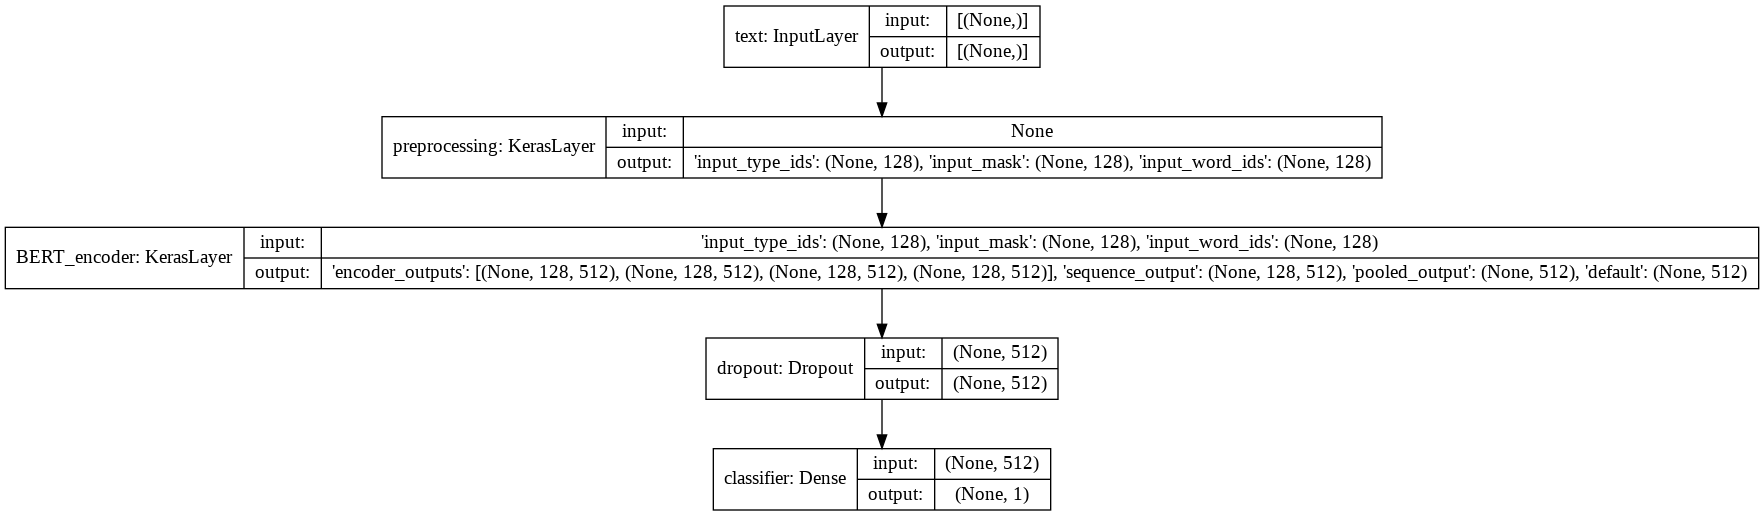

In [21]:
# 畫出模型圖

keras.utils.plot_model(
    classifier_model,
    show_shapes=True
)

In [22]:
# 訓練!

loss = keras.losses.BinaryCrossentropy(from_logits=True)    # 最後一層沒有sigmoid, 因此from_logits=True
metrics = tf.metrics.BinaryAccuracy()

In [24]:
# 準備

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(
    dataset=train_ds
).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

In [25]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [26]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 164s 254ms/step - loss: 0.4864 - binary_accuracy: 0.7395 - val_loss: 0.3744 - val_binary_accuracy: 0.8292
Epoch 2/5
625/625 [==============================] - 155s 247ms/step - loss: 0.3290 - binary_accuracy: 0.8533 - val_loss: 0.3871 - val_binary_accuracy: 0.8476
Epoch 3/5
625/625 [==============================] - 154s 247ms/step - loss: 0.2489 - binary_accuracy: 0.8963 - val_loss: 0.4190 - val_binary_accuracy: 0.8544
Epoch 4/5
625/625 [==============================] - 156s 249ms/step - loss: 0.1908 - binary_accuracy: 0.9240 - val_loss: 0.4511 - val_binary_accuracy: 0.8578
Epoch 5/5
625/625 [==============================] - 155s 248ms/step - loss: 0.1514 - binary_accuracy: 0.9423 - val_loss: 0.4802 - val_binary_accuracy: 0.8548


In [27]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 85s 109ms/step - loss: 0.4581 - binary_accuracy: 0.8584
Loss: 0.45805370807647705
Accuracy: 0.8584399819374084


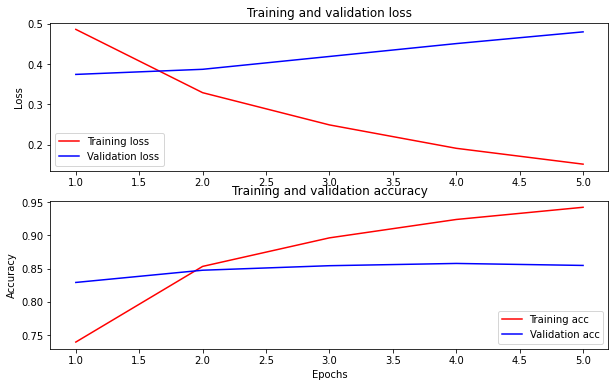

In [30]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [31]:
# 匯出 for inference

dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./imdb_bert/assets


INFO:tensorflow:Assets written to: ./imdb_bert/assets


In [32]:
# load model

reloaded_model = tf.saved_model.load(saved_model_path)

In [33]:
# 測試

def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                            for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

# tf.constant: 從類似張量的對象創建一個常數張量。
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999536
input: The movie was great!           : score: 0.995809
input: The movie was meh.             : score: 0.861789
input: The movie was okish.           : score: 0.040768
input: The movie was terrible...      : score: 0.000461

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999536
input: The movie was great!           : score: 0.995809
input: The movie was meh.             : score: 0.861789
input: The movie was okish.           : score: 0.040768
input: The movie was terrible...      : score: 0.000461



In [34]:
# TF Serving, 專門為了生產環境使用!



serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999536
input: The movie was great!           : score: 0.995809
input: The movie was meh.             : score: 0.861789
input: The movie was okish.           : score: 0.040768
input: The movie was terrible...      : score: 0.000461

